![Logo 1](img/aitech-logotyp-1.jpg)
<div class="alert alert-block alert-info">
<h1> Widzenie komputerowe </h1>
<h2> 02. <i>Operacje binarne na obrazach</i> [laboratoria]</h2> 
<h3>Andrzej Wójtowicz (2021)</h3>
</div>

![Logo 2](img/aitech-logotyp-2.jpg)

# Progowanie

Podczas pracy z obrazami często potrzebne jest operowanie na obrazach, które przyjmują tylko dwie skrajne wartości. Po operacji tzw. progowania (ang. *thresholding*) na obrazie będziemy mieli piksele czarne o wartości 0 lub białe o wartości 255 (lub 1, w zależności od tego na jakim typie danych i w jakiej dziedzinie operujemy).

Na początku załadujmy niezbędne biblioteki.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Podczas tych zajęć skupimy się na ręcznym progowaniu. Jeśli dla obrazu w skali odcieni szarości chcielibyśmy w naszym kodzie uzyskać obraz binarny, to moglibyśmy hipotetycznie wybrać jedną z trzech opcji:

1. przejść w pętli po wszystkich pikselach, sprawdzić czy wartość danego piksela jest mniejsza od wybranej wartości progowej i na tej podstawie ustawić nowy piksel jako czarny lub biały,
2. użyć biblioteki *NumPy* (i przy pomocy wektoryzacji stworzyć macierz binarną),
3. użyć biblioteki *OpenCV*.

W tym miejscu nie będziemy co prawda robili eksperymentu, jednak co do zasady mając do wyboru gotowe zoptymalizowane biblioteki, zdecydowanie *nie* powinniśmy implementować algorytmów od podstaw (no chyba że podczas zajęć uczymy się mechaniki danych algorytmów; na produkcji raczej będziemy preferowali gotowe rozwiązania). Różnica w wydajności między naiwną ręczną implementacją a użyciem gotowej biblioteki może być, lekko licząc, kilkudziesięciokrotna.

Wykorzystajmy na początek funkcję [`cv2.threshold()`](https://docs.opencv.org/4.5.3/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57) do zwykłego progowania z progiem ustalonym na 100:

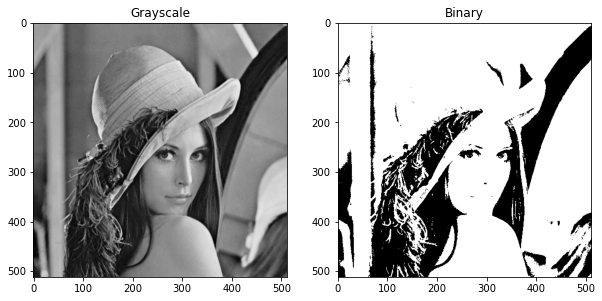

In [2]:
img = cv.imread("img/lena.png", cv.IMREAD_GRAYSCALE)
_, img_bin = cv.threshold(img, 100, 255, cv.THRESH_BINARY)

plt.figure(figsize=[10,10])
plt.subplot(121) 
plt.imshow(img, cmap='gray')
plt.title("Grayscale")
plt.subplot(122)
plt.imshow(img_bin, cmap='gray')
plt.title("Binary");

Istnieją również [inne metody ręcznego progowania](https://docs.opencv.org/4.5.3/d7/d1b/group__imgproc__misc.html#gaa9e58d2860d4afa658ef70a9b1115576), które np. przycinają wartości do progu (w dokumentacji znajdują się wzory i przykładowe wykresy opisujące poszczególne typy operacji). Poniżej możemy zobaczyć wynik dla tych operacji:

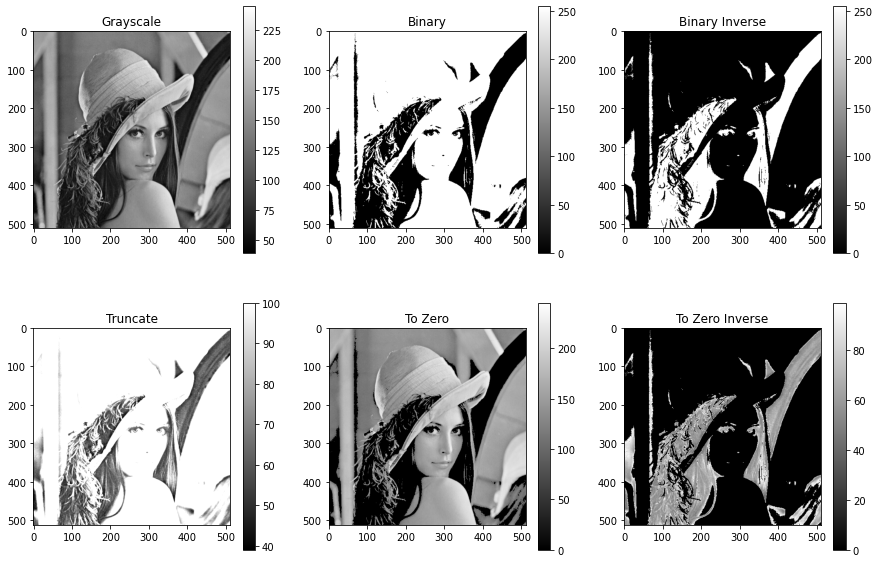

In [3]:
_, img_bin = cv.threshold(img, 100, 255, cv.THRESH_BINARY)
_, img_bin_inv = cv.threshold(img, 100, 255, cv.THRESH_BINARY_INV)
_, img_trunc = cv.threshold(img, 100, 255, cv.THRESH_TRUNC)
_, img_to_zero = cv.threshold(img, 100, 255, cv.THRESH_TOZERO)
_, img_to_zero_inv = cv.threshold(img, 100, 255, cv.THRESH_TOZERO_INV)

images = (img, img_bin, img_bin_inv, img_trunc, img_to_zero, img_to_zero_inv)
titles = ("Grayscale", "Binary", "Binary Inverse", "Truncate", "To Zero", "To Zero Inverse")

plt.figure(figsize=[15,10])

for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(231+i)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.colorbar()

Spójrzmy na słupki z zakresami wartości. Możemy zauważyć, że dla poszczególnych obrazów wartości minimalne i maksymalne biblioteka Matplotlib automatycznie przeskalowała do skrajnych wartości dla bieli i czerni. Aby na etapie wyświetlania usunąć to przekłamanie, musimy nieco zmienić funkcję `matplotlib.pyplot.imshow()` podając prawdziwe zakresy wartości:

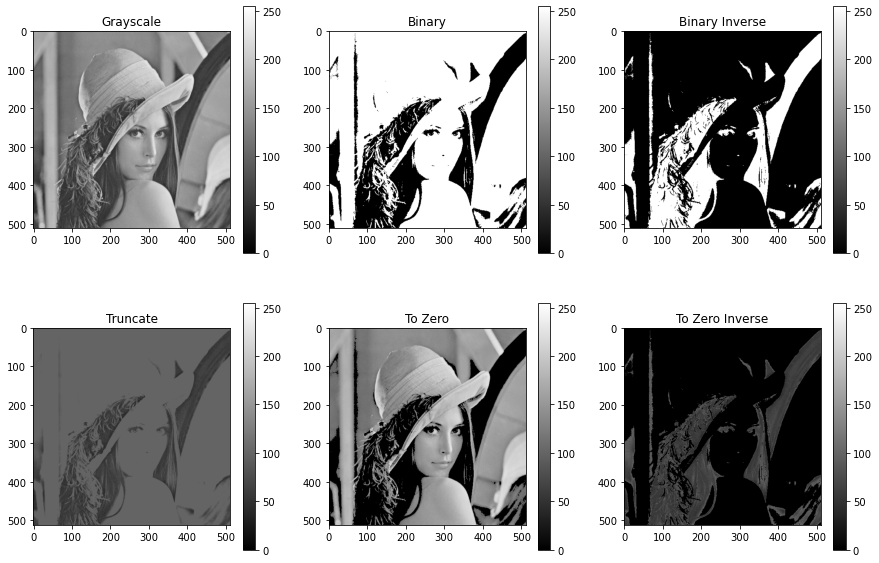

In [4]:
plt.figure(figsize=[15,10])

for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(231+i)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.colorbar()

## Operacje morfologiczne

Morfologia matematyczna jest narzędziem, które pozwala m.in. na uzupełnianie ubytków w uszkodzonych/zniekształconych obrazach lub wyciszanie (a czasem i usuwanie) prostych kształtów. Na początku omówimy proste operacje typu erozja i dylacja, a następnie ich złożenie. Dodajmy, że operacje te działają zasadniczo na wszystkich typach obrazów (nie tylko binarnych).

### Element strukturyzujący, erozja i dylacja

Na początku będziemy potrzebowali tzw. element strukturyzujący. Jest to binarna maska (mała macierz), najczęściej o nieparzystym wymiarze i zawierająca jakiś prosty, regularny kształt. Kształt ten może być dowolny, jednak w praktyce wykorzystywanych jest [kilka standardowych](https://docs.opencv.org/4.5.3/d4/d86/group__imgproc__filter.html#gac2db39b56866583a95a5680313c314ad). Do łatwego uzyskania elementu użyjemy funkcji [`cv.getStructuringElement()`](https://docs.opencv.org/4.5.3/d4/d86/group__imgproc__filter.html#gac342a1bb6eabf6f55c803b09268e36dc).

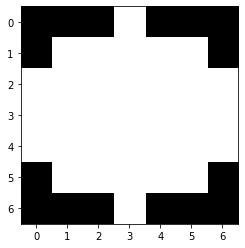

In [5]:
kernel_ellipse = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
plt.imshow(kernel_ellipse, cmap='gray');

No, powiedzmy, że jest to elipsa ;) Tutaj użyliśmy dość dużego elementu o wymariach 7 na 7, jednak w praktyce może być on mniejszy.

W jaki sposób możemy wykorzystać taki element strukturyzujący? Element strutkruryzujący jest maską binarną, którą możemy *przyłożyć* dla każdego piksela jakiegoś obrazu (najczęściej przykłada się go centralnie do piksela). Białe piksele maski mówią nam które sąsiadujące piksele powinniśmy wziąć w danym momencie pod uwagę. Mając wartości tych pikseli, możemy policzyć ich wartość minimalną (erozja) lub maksymalną (dylacja) i ustawić w nowym obrazie na współrzędznych danego piksela. Wykorzystuje się tutaj odpowiednio funkcje [`cv.erode()`](https://docs.opencv.org/4.5.3/d4/d86/group__imgproc__filter.html#gaeb1e0c1033e3f6b891a25d0511362aeb) i [`cv.dilate()`](https://docs.opencv.org/4.5.3/d4/d86/group__imgproc__filter.html#ga4ff0f3318642c4f469d0e11f242f3b6c). Poniżej możemy zobaczyć działanie na klasycznym przykładzie z monetami:

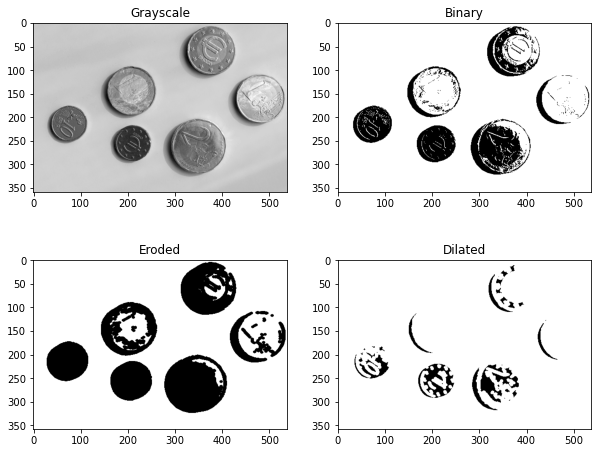

In [6]:
coins = cv.imread("img/coins.png", cv.IMREAD_GRAYSCALE)
_, coins_bin = cv.threshold(coins, 125, 255, cv.THRESH_BINARY)

coins_eroded = cv.erode(coins_bin, kernel_ellipse, iterations=1)
coins_dilated = cv.dilate(coins_bin, kernel_ellipse, iterations=1)

plt.figure(figsize=[10,8])
plt.subplot(221)
plt.imshow(coins, cmap='gray')
plt.title("Grayscale")
plt.subplot(222)
plt.imshow(coins_bin, cmap='gray')
plt.title("Binary")
plt.subplot(223)
plt.imshow(coins_eroded, cmap='gray')
plt.title("Eroded")
plt.subplot(224)
plt.imshow(coins_dilated, cmap='gray')
plt.title("Dilated");

Możemy zauważyć, że zastosowanie erozji spowodowało wypełnienie w większym lub mniejszym stopniu dziur w zbinaryzowanych monetach. Z kolei dylacja spowodowała prawie zaniknięcie obrazu. Użyliśmy tutaj jednej iteracji, jednak możliwe jest kilkukrotne wykonanie erozji lub dylacji.

Poniżej możemy zobaczyć, że erozja i dylacja są w pewien sposób komplementarne:

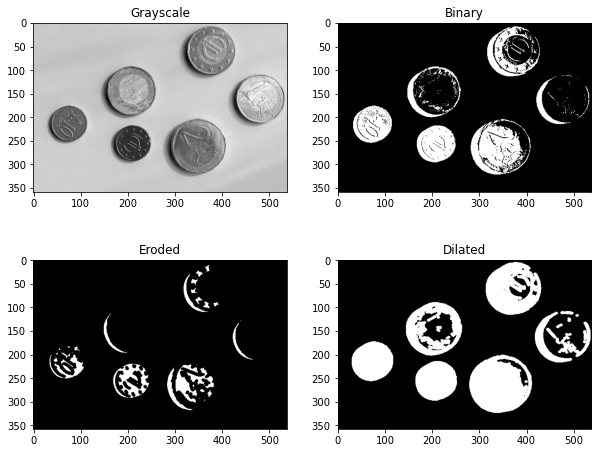

In [7]:
coins = cv.imread("img/coins.png", cv.IMREAD_GRAYSCALE)
_, coins_bin = cv.threshold(coins, 125, 255, cv.THRESH_BINARY_INV)

coins_eroded = cv.erode(coins_bin, kernel_ellipse, iterations=1)
coins_dilated = cv.dilate(coins_bin, kernel_ellipse, iterations=1)

plt.figure(figsize=[10,8])
plt.subplot(221)
plt.imshow(coins, cmap='gray')
plt.title("Grayscale")
plt.subplot(222)
plt.imshow(coins_bin, cmap='gray')
plt.title("Binary")
plt.subplot(223)
plt.imshow(coins_eroded, cmap='gray')
plt.title("Eroded")
plt.subplot(224)
plt.imshow(coins_dilated, cmap='gray')
plt.title("Dilated");

Element strukturyzujący w kształcie elipsy całkiem dobrze zadziałał w przypadku usunięcia dziur w owalnych kształtach. Z drugiej strony musimy być świadomi, że inne, arbitralne kształty mogą być przydatne w specjalnych zastosowaniach (np. pionowe lub ukośne linie/kreski).

### Otwarcie i zamknięcie

Złożenie operacji dylacji i erozji może posłużyć np. do uzupełnienia przerw między kształtami lub wyciszenia drobnych szumów. Tzw. *otwarcie* dotyczy erozji, po której następuje dylacja, co w konsekwencji usuwa białe plamy i przerwy. Z kolei tzw. *zamknięcie* to dylacja, po której następuje erozja, i taka operacja usuwa czarne plamy i przerwy. Jeśli interesuje nas wypełnienie przerw, to takie złożenia operacji nie będą powodowały *rozrastania* obiektów. Użyjemy tutaj funkcji [`cv.morphologyEx()`](https://docs.opencv.org/4.5.3/d4/d86/group__imgproc__filter.html#ga67493776e3ad1a3df63883829375201f).

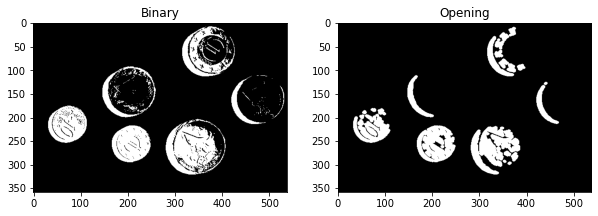

In [8]:
coins_opened = cv.morphologyEx(coins_bin, cv.MORPH_OPEN, kernel_ellipse, iterations=1)

plt.figure(figsize=[10,10])

plt.subplot(121)
plt.imshow(coins_bin, cmap='gray')
plt.title("Binary")
plt.subplot(122)
plt.imshow(coins_opened, cmap='gray')
plt.title("Opening");

### Zadanie 1

Wczytaj obraz `text_no_ocr.png`, który zawiera fragment starych notatek (z przedmiotu "E-gospodarka" dra Michała Rena) posiadających zabezpieczenie przed dalszym przetwarzaniem. Spróbuj usunąć niechciane kształty (wynik nie musi być dokładny - może uzyskasz lepszy efekt?).

TypeError: Image data of dtype object cannot be converted to float

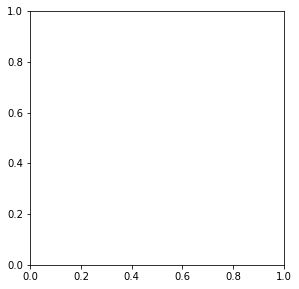

In [9]:
text_no_ocr = cv.imread("text_no_ocr.png", cv.IMREAD_GRAYSCALE)
plt.figure(figsize=[10,10])
plt.subplot(121) 

plt.imshow(text_no_ocr, cmap='gray')


![Przykładowy wynik](img/text_no_ocr_sample_result.png)

## Analiza połączonych komponentów

Jeśli na naszym obrazie binarnym posiadamy zwarte grupy obiektów, to możemy im nadać etykiety i je policzyć. Na poniższym zdjęciu możemy policzyć litery napisu:

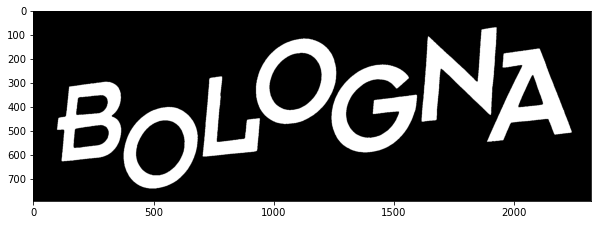

In [10]:
bologna = cv.imread("img/bologna.png", cv.IMREAD_GRAYSCALE)
_, bologna_bin = cv.threshold(bologna, 127, 255, cv.THRESH_BINARY)

plt.figure(figsize=[10,5])

plt.imshow(bologna_bin, cmap='gray');

Do nadania etykiet użyjemy funkcji [`cv.connectedComponents()`](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#gaedef8c7340499ca391d459122e51bef5):

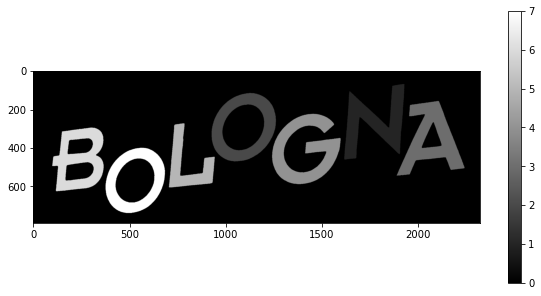

In [11]:
_, bologna_labels = cv.connectedComponents(bologna_bin)

plt.figure(figsize=[10,5])

plt.imshow(bologna_labels, cmap='gray')
plt.colorbar();

Zauważmy, że wynikowy obraz ma 8 etykiet, gdzie 0 oznacza tło, a kolejne siedem są przypisane do poszczególnych liter. Możemy wyświetlić poszczególne fragmenty obrazu dotyczące danej etykiety:

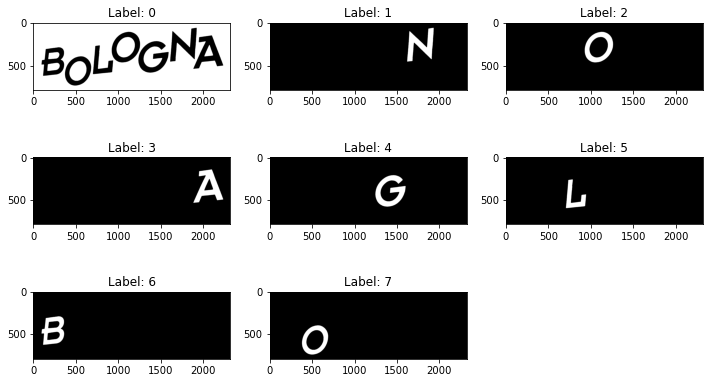

In [12]:
bologna_n = bologna_labels.max()

plt.figure(figsize=[12,7])

for i in range(bologna_n+1):
    plt.subplot(331+i)
    plt.imshow(bologna_labels==i, cmap='gray')
    plt.title(f"Label: {i}")

Do wygodnego wyświetlenia pokolorowanych etykiet możemy użyć map kolorów. Pracując z biblioteką Matplotlib możemy wyświetlić taki obraz wprost i użyć ew. odpowiedniej [mapy kolorów](https://matplotlib.org/stable/tutorials/colors/colormaps.html), np.:

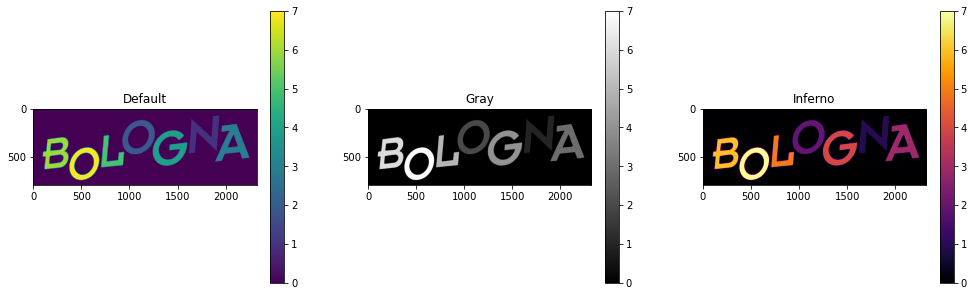

In [13]:
plt.figure(figsize=[17,5])

plt.subplot(131)
plt.imshow(bologna_labels)
plt.title("Default")
plt.colorbar()
plt.subplot(132)
plt.imshow(bologna_labels, cmap='gray')
plt.colorbar()
plt.title("Gray")
plt.subplot(133)
plt.imshow(bologna_labels, cmap='inferno')
plt.colorbar()
plt.title("Inferno");

Biblioteka OpenCV również posiada obsługę map kolorów, co może być pomocne gdybyśmy chcieli np. wyeksportować obraz. Na początku możemy przekonwertować obraz do przedziału `[0; 255]` (znajdujemy minimalną i maksymalną wartość przy pomocy [`cv.minMaxLoc()`](https://docs.opencv.org/4.5.3/d2/de8/group__core__array.html#gab473bf2eb6d14ff97e89b355dac20707)), a następnie używamy funkcji [`cv.applyColorMap()`](https://docs.opencv.org/4.5.3/d3/d50/group__imgproc__colormap.html#gadf478a5e5ff49d8aa24e726ea6f65d15) podając wybraną [mapę](https://docs.opencv.org/4.5.3/d3/d50/group__imgproc__colormap.html#ga9a805d8262bcbe273f16be9ea2055a65) i otrzymując obraz BGR, np.:

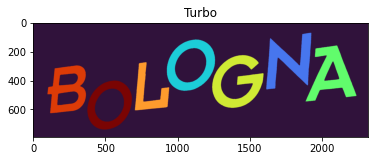

In [14]:
val_min, val_max, _, _ = cv.minMaxLoc(bologna_labels)
bologna_labels_norm = 255 * (bologna_labels - val_min)/(val_max - val_min)
bologna_labels_norm = np.uint8(bologna_labels_norm)

bologna_labels_turbo = cv.applyColorMap(bologna_labels_norm, cv.COLORMAP_TURBO)
plt.imshow(bologna_labels_turbo[:,:,::-1])
plt.title("Turbo");

## Kontury

W widzeniu komputerowym bardzo często chcemy nie tylko znaleźć pewne obiekty, ale również zaznaczyć ich obrys (kontury). Poniżej znajduje się kilka przykładów - będziemy co prawda działali na obrazie w skali odcieni szarości, aczkolwiek w pewnych zastosowaniach lepsze efekty dałaby praca na obrazie czarno-białym.

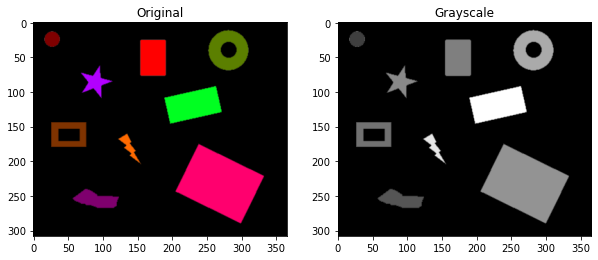

In [15]:
shapes = cv.imread("img/shapes.png", cv.IMREAD_COLOR)
shapes_gray = cv.cvtColor(shapes, cv.COLOR_BGR2GRAY)

plt.figure(figsize=[10,5])

plt.subplot(121)
plt.imshow(shapes[:,:,::-1])
plt.title("Original")
plt.subplot(122)
plt.imshow(shapes_gray, cmap='gray')
plt.title("Grayscale");

Przy pomocy [`cv.findContours()`](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0) uzyskujemy kontury obiektów oraz opcjonalną macierz opisującą ich hierarchię. Drugi parametr funkcji opisuje [sposób wyznaczania konturów](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#ga819779b9857cc2f8601e6526a3a5bc71), a trzeci [algorytm aproksymacji konturów](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#ga4303f45752694956374734a03c54d5ff).

In [16]:
shapes_contours, _ = cv.findContours(shapes_gray, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
print(f"No. of contours: {len(shapes_contours)}")

No. of contours: 11


Przy pomocy [`cv.drawContours()`](https://docs.opencv.org/4.5.3/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc) możemy nanieść kontury na obraz. Zauważmy, że mamy tutaj oznaczone zewnętrzne i wewnętrzne kontury:

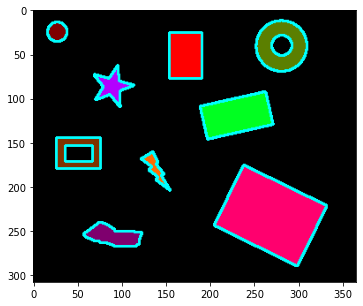

In [17]:
shapes_with_contours = shapes.copy()

cv.drawContours(shapes_with_contours, shapes_contours, -1, (255,255,0), 2)

plt.figure(figsize=[10,5])
plt.imshow(shapes_with_contours[:,:,::-1]);

Możemy również ograniczyć się tylko do zewnętrznych konturów (parametr `cv.RETR_EXTERNAL`):

No. of contours: 9


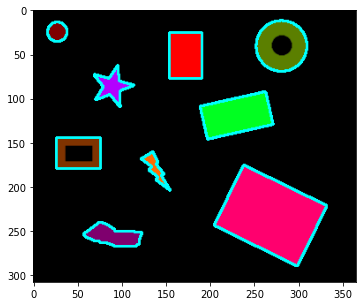

In [18]:
shapes_contours, _ = cv.findContours(shapes_gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
print(f"No. of contours: {len(shapes_contours)}")
shapes_with_contours = shapes.copy()

cv.drawContours(shapes_with_contours, shapes_contours, -1, (255,255,0), 2)

plt.figure(figsize=[10,5])
plt.imshow(shapes_with_contours[:,:,::-1]);

Poniżej mamy zaznaczony obrys konturu wybranego obiektu:

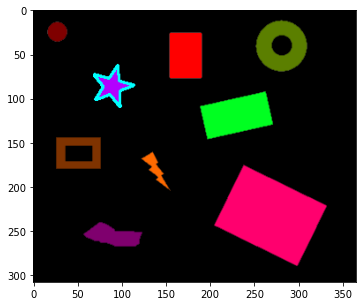

In [19]:
shapes_with_contours = shapes.copy()

cv.drawContours(shapes_with_contours, [shapes_contours[5]], -1, (255,255,0), 2)

plt.figure(figsize=[10,5])
plt.imshow(shapes_with_contours[:,:,::-1]);

Poniżej możemy zobaczyć jak przy pomocy tzw. [momentów](https://en.wikipedia.org/wiki/Image_moment) są wyliczane środki ciężkości poszczególnych konturów. Każdy kontur jest również opisany żółtą etykietą liczbową, ale w związku z tym, że czasem mamy kontur zewnętrzny i wewnętrzny blisko siebie, to niektóre etykiety nakładają się na siebie. Dodatkowo, tym razem kontury wykryjemy z informacją o drzewiastej hierarchii (parametr `cv.RETR_TREE`, za chwilę opiszemy co tam się znajduje).

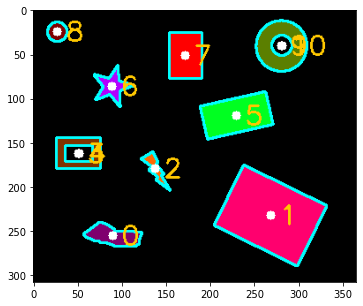

In [20]:
shapes_contours, shapes_hierarchy = cv.findContours(shapes_gray, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
shapes_with_contours = shapes.copy()

cv.drawContours(shapes_with_contours, shapes_contours, -1, (255,255,0), 2)

for idx, contour in enumerate(shapes_contours):
    M = cv.moments(contour)
    x = int(round(M["m10"]/M["m00"]))
    y = int(round(M["m01"]/M["m00"]))
    
    cv.circle(shapes_with_contours, (x,y), 5, (255,255,255), -1)
    cv.putText(shapes_with_contours, str(idx), (x+10, y+10), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 200, 255), 2)
    
plt.figure(figsize=[10,5])
plt.imshow(shapes_with_contours[:,:,::-1]);

W zmiennej `shapes_hierarchy` mamy macierz opisującą hierarchię konturów. Dla każdego wiersza (konturu) kolejne kolumny opisują odpowiednio: indeks następnego konturu, indeks poprzedniego konturu, indeks pierwszego dziecka oraz indeks rodzica (wartość ujemna oznacza, że dane pole nie ma zastosowania).

In [21]:
print(shapes_hierarchy)

[[[ 1 -1 -1 -1]
  [ 2  0 -1 -1]
  [ 3  1 -1 -1]
  [ 5  2  4 -1]
  [-1 -1 -1  3]
  [ 6  3 -1 -1]
  [ 7  5 -1 -1]
  [ 8  6 -1 -1]
  [ 9  7 -1 -1]
  [-1  8 10 -1]
  [-1 -1 -1  9]]]


Przy pomocy [`cv.contourArea()`](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#ga2c759ed9f497d4a618048a2f56dc97f1) i [`cv.arcLength()`](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#ga8d26483c636be6b35c3ec6335798a47c) możemy policzyć odpowiednio pole powierzchni i obwód kształtu:

In [22]:
for idx, contour in enumerate(shapes_contours):
    area = cv.contourArea(contour)
    perimeter = round(cv.arcLength(contour, True), 1)
    print(f"Contour id {idx: >2}: area = {area: >6}, perimeter = {perimeter: >5}")

Contour id  0: area = 1063.0, perimeter = 161.4
Contour id  1: area = 8017.5, perimeter = 390.0
Contour id  2: area =  375.0, perimeter = 133.0
Contour id  3: area = 1750.0, perimeter = 170.0
Contour id  4: area =  556.0, perimeter =  95.7
Contour id  5: area = 2917.0, perimeter = 244.7
Contour id  6: area =  729.5, perimeter = 185.6
Contour id  7: area = 1922.0, perimeter = 175.7
Contour id  8: area =  380.5, perimeter =  73.4
Contour id  9: area = 2596.5, perimeter = 191.6
Contour id 10: area =  407.0, perimeter =  75.6


Dla znalezionych kształtów często chcemy wyznaczyć ramkę ograniczającą i możemy to zrobić na kilka sposobów. Poniżej przy pomocy [`cv.boundingRect()`](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#ga103fcbda2f540f3ef1c042d6a9b35ac7) i [`cv.rectangle()`](https://docs.opencv.org/4.5.3/d6/d6e/group__imgproc__draw.html#ga07d2f74cadcf8e305e810ce8eed13bc9) nanosimy prostokąty:

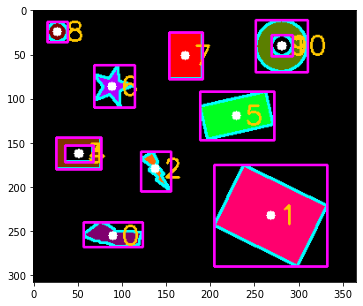

In [23]:
shapes_with_bb = shapes_with_contours.copy()
for contour in shapes_contours:
    x,y,w,h = cv.boundingRect(contour)
    cv.rectangle(shapes_with_bb, (x,y), (x+w,y+h), (255,0,255), 2)
    
plt.figure(figsize=[10,5])
plt.imshow(shapes_with_bb[:,:,::-1]);

Czasami wygodniej jest umieścić minimalny obrys prostokąta, co możemy uzyskać przy pomocy [`cv.minAreaRect()`](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#ga3d476a3417130ae5154aea421ca7ead9) i [`cv.boxPoints()`](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#gaf78d467e024b4d7936cf9397185d2f5c):

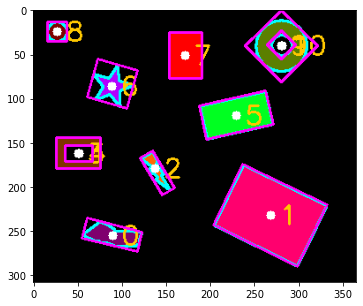

In [24]:
shapes_with_bb = shapes_with_contours.copy()
for contour in shapes_contours:
    rect = cv.minAreaRect(contour)
    box_points = np.int0(cv.boxPoints(rect))
    cv.drawContours(shapes_with_bb, [box_points], -1, (255,0,255), 2)
    
plt.figure(figsize=[10,5])
plt.imshow(shapes_with_bb[:,:,::-1]);

Poniżej mamy przykład z okręgiem przy pomocy [`cv.minEnclosingCircle()`](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#ga8ce13c24081bbc7151e9326f412190f1):

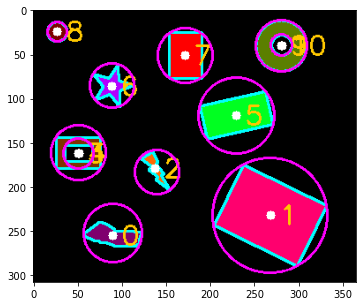

In [25]:
shapes_with_bb = shapes_with_contours.copy()
for contour in shapes_contours:
    (x,y), radius = cv.minEnclosingCircle(contour)
    cv.circle(shapes_with_bb, (int(x),int(y)), int(round(radius)), (255,0,255), 2)
    
plt.figure(figsize=[10,5])
plt.imshow(shapes_with_bb[:,:,::-1]);

Możemy również umieścić elipsy przy pomocy [`cv.fitEllipse()`](https://docs.opencv.org/4.5.3/d3/dc0/group__imgproc__shape.html#gaf259efaad93098103d6c27b9e4900ffa), ale w tym przypadku kontur musi składać się z co najmniej 5 punktów:

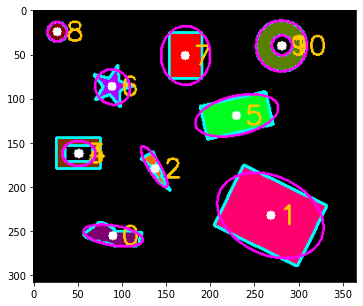

In [26]:
shapes_with_bb = shapes_with_contours.copy()
for contour in shapes_contours:
    if len(contour) < 5:
        continue
    ellipse = cv.fitEllipse(contour)
    cv.ellipse(shapes_with_bb, ellipse, (255,0,255), 2)
    
plt.figure(figsize=[10,5])
plt.imshow(shapes_with_bb[:,:,::-1]);

## Wykrywanie obszarów/plam

Do wykrywania obszarów/plam (ang. *blobs*) posiadających wspólne cechy (np. rozmiar, kształt, wartości pikseli) możemy użyć [`cv.SimpleBlobDetector_create()`](https://docs.opencv.org/4.5.3/d0/d7a/classcv_1_1SimpleBlobDetector.html#a1d7a06c8b8749207a978e42cd8d0cdf6), a następnie używamy metody `detect()`. W poniższym przykładzie użyjemy domyślnych wartości detektora.

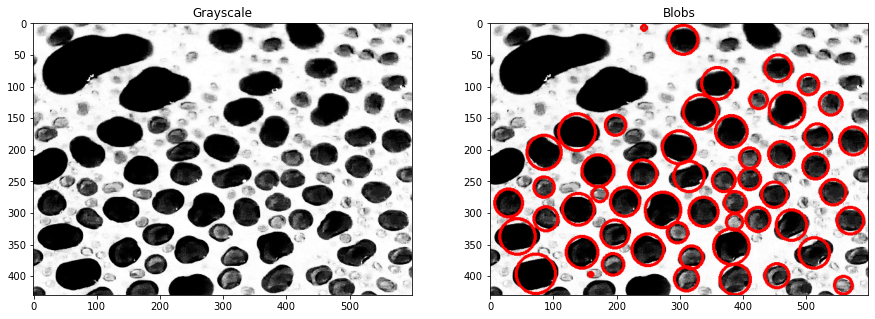

In [27]:
blobs_gray = cv.imread("img/blobs.png", cv.IMREAD_GRAYSCALE)
 
blob_detector = cv.SimpleBlobDetector_create()

keypoints = blob_detector.detect(blobs_gray)

blobs_color = cv.cvtColor(blobs_gray, cv.COLOR_GRAY2BGR)
 
for kp in keypoints:
    x, y = kp.pt
    x = int(round(x))
    y = int(round(y))

    radius = int(round(kp.size/2))

    cv.circle(blobs_color, (x,y), radius, (0,0,255), 3)

plt.figure(figsize=[15,5])
plt.subplot(121)
plt.imshow(blobs_gray, cmap='gray')
plt.title("Grayscale")
plt.subplot(122)
plt.imshow(blobs_color[:,:,::-1])
plt.title("Blobs");

Parametry ustawia się poprzez atrybuty obiektu zwracanego przez [`cv.SimpleBlobDetector_Params()`](https://docs.opencv.org/4.5.3/d8/da7/structcv_1_1SimpleBlobDetector_1_1Params.html). Po ustawieniu parametrów obiekt z parametrami przekazuje się jako argument `cv.SimpleBlobDetector_create()`.

Detektor działa następująco:

1. Obraz źródłowy jest przekształcany do obrazów binarnych poprzez progowanie z wartościami odcięcia od `minThreshold` do `maxThreshold` z krokiem `thresholdStep`.
2. Dla każdego obrazu binarnego znajdowane są połączone komponenty przy pomocy `cv.findContours()` oraz obliczane są współrzędne ich środków.
3. Środki z kilku obrazów binarnych są grupowane na podstawie ich współrzędnych. Te, które znajdują się blisko siebie, odpowiadają jednej plamie/obszarowi (kontroluje się to poprzez parametr `minDistBetweenBlobs`).
4. Na podstawie wyznaczonych wcześniej grup obliczane są końcowe współrzędne środków plam/obszarów oraz ich promienie, tak by zwrócić je jako lokalizacje i rozmiary punktów kluczowych.

Detektor dokonuje kilku filtracji zwracanych plam/obszarów. Poszczególne filtry ustawia się poprzez parametry `filterBy*` nadając im wartość `True` lub `False`. Można filtrować według:

1. koloru (`filterByColor = True`), tj. następuje porównanie intensywności środka plamy/obszaru z obrazu binarnego do wartości ustawionej w `blobColor`; jeśli są różne, to plama/obszar jest odfiltrowana; wartość `blobColor = 0` wyodrębnia czarne plamy/obszary, a `blobColor = 255` jasne,
2. powierzchni (`filterByArea = True`), tj. plamy/obszary mają mieć powierzchnię między `minArea` a `maxArea`; np. ustawienie `minArea = 100` spowoduje odfiltrowanie plam/obszarów, których powierzchnia stanowi mniej niż 100 pikseli,
3. okrągłości (`filterByCircularity = True`), tj. miara okrągłości plamy/obszaru `4 * pi * pole powierzchni / obwód^2` ma być między `minCircularity` a `maxCircularity`; np. regularny sześciokąt ma większą okrągłość niż kwadrat; np. okrąg ma miarę `1.0`, a kwadrat ok. `0.785`,
4. inercji (`filterByInertia = True`), tj. jej wartość ma się znaleźć między `minInertiaRatio` a `maxInertiaRatio`; miara ta określa jak bardzo wydłużony jest dany kształt, np. dla okręgu wartość ta wynosi 1, dla elipsy mieści się w przedziale od 0 do 1, a dla linii wynosi 0; aby odfiltrować po inercji można ustawić `0 ≤ minInertiaRatio ≤ 1` oraz `maxInertiaRatio ≤ 1`,
5. wypukłości (`filterByConvexity = True`), tj. `pole powierzchni / pole powierzchni otoczki wypukłej` ma być między `minConvexity` a `maxConvexity`; aby odfiltrować po wypukłości można ustawić `0 ≤ minConvexity ≤ 1` oraz `maxConvexity ≤ 1`.

Domyślne wartości parametrów są dostrojone do ekstrakcji ciemnych, okrągłych plam.

Poniżej znajduje się przykład skonfigurowania parametrów pod kątem progu i minimalnego pola powierzchni:

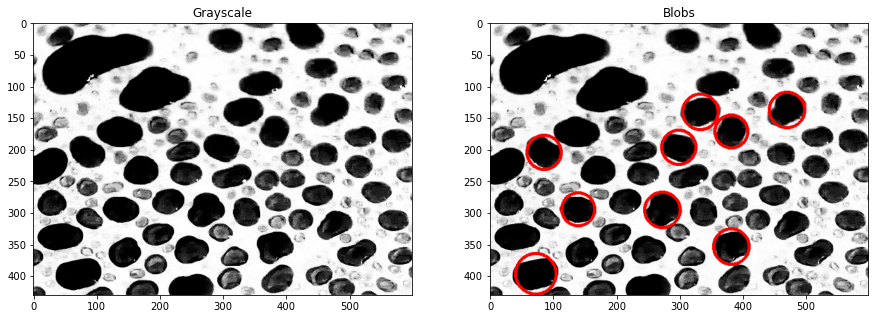

In [28]:
params = cv.SimpleBlobDetector_Params()
params.minThreshold = 200
params.maxThreshold = 255
params.filterByArea = True
params.minArea = 2000

blob_detector = cv.SimpleBlobDetector_create(params)

keypoints = blob_detector.detect(blobs_gray)

blobs_color = cv.cvtColor(blobs_gray, cv.COLOR_GRAY2BGR)
 
for kp in keypoints:
    x, y = kp.pt
    x = int(round(x))
    y = int(round(y))

    radius = int(round(kp.size/2))

    cv.circle(blobs_color, (x,y), radius, (0,0,255), 3)

plt.figure(figsize=[15,5])
plt.subplot(121)
plt.imshow(blobs_gray, cmap='gray')
plt.title("Grayscale")
plt.subplot(122)
plt.imshow(blobs_color[:,:,::-1])
plt.title("Blobs");

### Zadanie 2

Spróbuj wykryć i oznaczyć monety z pliku `img/coins.png`. Przykładowy wynik znajduje się poniżej (użyto schematu kolorów *inferno*, kolejność wykrytych monet nie jest istotna).

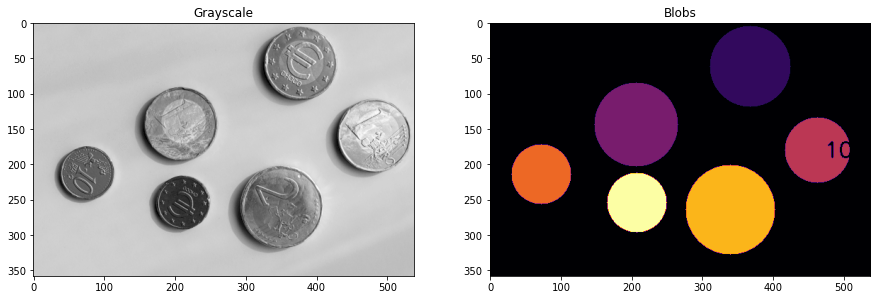

In [55]:
params = cv.SimpleBlobDetector_Params()
params.minThreshold = 100
params.maxThreshold = 255
params.filterByArea = True
params.minArea = 500
params.minConvexity = 0.36
params.maxArea = 50000

blobs_gray = cv.imread("img/coins.png", cv.IMREAD_GRAYSCALE)

blob_detector = cv.SimpleBlobDetector_create(params)

keypoints = blob_detector.detect(blobs_gray)

blobs_color = cv.cvtColor(blobs_gray, cv.COLOR_GRAY2BGR)
image_empty = np.zeros((358, 538, 3), dtype='uint8')
for kp in keypoints:
    x, y = kp.pt
    x = int(round(x))
    y = int(round(y))

    radius = int(round(kp.size/2))

    cv.circle(image_empty, (x,y), radius, (255,255,255), -1)

image_empty = cv.cvtColor(image_empty, cv.COLOR_BGR2GRAY)
_, image_empty = cv.connectedComponents(image_empty)



plt.figure(figsize=[15,5])
plt.subplot(121)
plt.imshow(blobs_gray, cmap='gray')
plt.title("Grayscale")
plt.subplot(122)
plt.imshow(image_empty , cmap='inferno')
plt.title("Blobs");

![Wykryte monety](img/coins_detected.png)